**Load Gesture file library Dataset and Clean it by standard pre-processing**


Load the ARFF file: Read the .arff file and convert it to a pandas DataFrame.


Handle Missing Values: Clean the data by handling any missing or NaN values.


Scale the Data: Normalize or scale features if required.


Backward and Forward fill techniques -This is used to fill the missing values for both Numeric and Non-numeric data because Median and mean etc are not valid for non-numeric data.

**Converted into csv file for my better understanding**

**Clean Data and process the csv file**

Data Parsing: Convert any object-type columns to numeric types, turning any parsing errors into NaN.


Handle Missing Values: Use forward and backward fill to handle NaN values introduced during parsing.


Outlier Detection: Use the Isolation Forest algorithm to detect and remove outliers, setting a contamination rate for expected outliers.


Normalization: Use Min-Max scaling to bring all values into a [0, 1] range, or switch to Standard Scaling if preferred.



In [ ]:
import pandas as pd
from scipy.io import arff
from sklearn.preprocessing import StandardScaler
import numpy as np

# Load the ARFF file into a pandas DataFrame
file_path = '/content/UWaveGestureLibrary_TRAIN.arff'
data, meta = arff.loadarff(file_path)
df = pd.DataFrame(data)

# Decode byte strings if needed
for column in df.select_dtypes([object]):
    df[column] = df[column].apply(lambda x: x.decode('utf-8') if isinstance(x, bytes) else x)

# Convert any numpy.ndarray values to lists
for column in df.columns:
    df[column] = df[column].apply(lambda x: x.tolist() if isinstance(x, np.ndarray) else x)

# Fill missing values using forward fill and backward fill
df = df.ffill().bfill()

# Ensure numeric columns are of a correct type for scaling
numeric_columns = df.select_dtypes(include=['float64', 'int64']).columns
if len(numeric_columns) > 0:
    scaler = StandardScaler()
    df[numeric_columns] = scaler.fit_transform(df[numeric_columns])

# Display the head of the cleaned and preprocessed data
print("Cleaned and Preprocessed Data Head:")
print(df)
# Save the cleaned data to a new CSV file
output_csv_file = '/content/cleaned_UWaveGestureLibrary_TRAIN.csv'
df.to_csv(output_csv_file, index=False)
print(f"Cleaned data has been saved to {output_csv_file}")




Step 1 - In the self-supervised pre
training phase, a pre-defined pretext task is formulated for
 the deep learning algorithm to solve.

 Step 2-  Pseudo-labels for the
 pretext task are automatically generated based on specific
 attributes of the input data.

 Step 3-  Once the self-supervised pretraining process is completed, the acquired model can be
 transferred to downstream tasks.


### Pretext Tasks for Self-Supervised Learning


**THIS IS EXTRACTED FROM THE RESEARCH PAPER**

**1. Context-Based Methods:**
- **Rotation:** The network learns to identify general image features (e.g., edges, textures, spatial layouts) that are invariant to rotation, crucial for object recognition.
- **Colorization:** The model predicts the missing color channels (e.g., ab channels) for grayscale images, effectively restoring the original image to a colorful representation.
- **Jigsaw:** The task involves solving image puzzles, improving representation quality with higher model capacity and more complex problems.

**2. Contrastive Learning (CL):**
Contrastive learning promotes similarity between positive examples while maximizing the separation between negatives in latent space.
- **MoCo (Momentum Contrast):** Treats contrastive learning as a dictionary lookup task, differentiating positive and negative examples based on representations of instance views.
- **SimCLR:** Uses random augmentations (e.g., cropping, flipping) on mini-batch images. Negative instances are implicitly selected from the batch.
- **BYOL (Bootstrap Your Own Latent):** Uses Siamese networks (online and target), where the online network is updated constantly, and the target network is updated slowly to avoid collapse.
- **SimSiam:** Enhances BYOL with a "stop-gradient" operation to prevent collapse, making training more stable.
- **Barlow Twins:** Aims to reduce redundancy in embeddings by ensuring that each dimension carries unique information.
- **VICReg:** Extends Barlow Twins with variance regularization to maintain spread in the data, while also reducing redundancy and ensuring invariance.

**3. Generative Algorithms:**
Generative algorithms aim to model data distribution and reconstruct missing parts of images.
- **Masked Image Modeling (MIM):** Involves masking parts of an image and predicting the missing portions, helping models learn better image structures.
  - **MAE:** Masks up to 75% of an image, using a decoder to reconstruct missing areas. Suitable for smaller datasets.
  - **BEiT:** Similar to BERT in NLP, splits the image into tokens and predicts missing parts. Works well for large datasets.

**4. Contrastive Generative Algorithms:**
Combining contrastive learning with generative approaches to overcome the limitations of both.
- **GANs for Data Augmentation in CL:** Generative Adversarial Networks (GANs) create altered views of images to help contrastive learning models.
- **iBOT:** Combines BEiT's tokenization with cross-view distillation from DINO, using a teacher model for improved accuracy.
- **RePre and CMAE:** Incorporate image reconstruction with contrastive learning, providing better data scaling and preventing overfitting.

**5. Semi-Supervised Learning (SSL) & Multi-Instance Learning (MIL):**
- **SSL4:** Combines Self-Supervised Learning and Semi-Supervised Learning, leveraging both labeled and unlabeled data for training.
- **MIL:** Uses "bags" of instances (time-series segments) to predict outcomes. A bag is labeled positive if at least one instance is positive, often used when the task requires only a subset of the data to determine the outcome.

**6. Multi-View and Multi-Modal Learning:**
- **Multi-View Learning:** Represents the same data from multiple perspectives to improve understanding, often used in SSL and Semi-SL.
- **Multi-Modal Learning:** Uses multiple data sources (e.g., text, image, video) for training. Techniques like Fusion, Cross-modal learning, and Attention Mechanisms are employed, as seen in advanced models like CLIP.

**7. 3D Cloud Data and Autoencoders:**
- **Autoencoders & Capsule Networks:** Used to compress and reconstruct data, capturing spatial relationships between points, particularly in 3D cloud data.

**8. Test-Time Training (TTT):**
TTT helps manage bias and variance when test and training data are very different. By combining with MAE, it effectively handles data corrections and new data training, ensuring balanced performance.

---

This summary covers various pretext tasks and methodologies for enhancing self-supervised learning, each addressing challenges in different aspects of image understanding and representation learning.

**We'll consider 2 models - VIreg and simCLR**

MIL handles time series segmentation by labeling bags rather than individual segments, making it ideal for scenarios where specific gesture instances trigger classification.


VICReg or SimCLR (under CL) would enhance feature learning, ensuring that each gesture has a distinct representation, crucial for differentiating between similar gestures.


Together, MIL and CL (with VICReg) provide a comprehensive approach to capture gesture features effectively, ensuring both temporal coherence (MIL) and diverse, discriminative feature learning (VICReg or SimCLR). This combination maximizes the ability to classify gestures accurately within time series data.

In [ ]:
import random

# Define augmentation functions for time-series data

def time_warp(series, warp_factor=0.2):
    """
    Stretches or compresses the time series by a random factor within the specified range.
    """
    stretch_factor = 1 + (warp_factor * (np.random.rand() * 2 - 1))  # random factor between (1-warp_factor) and (1+warp_factor)
    warped_series = np.interp(np.arange(0, len(series), stretch_factor), np.arange(0, len(series)), series)
    return warped_series[:len(series)]  # Ensure same length after warping

def jitter(series, noise_level=0.05):
    """
    Adds small random noise to each point in the series.
    """
    noise = np.random.normal(0, noise_level, len(series))
    return series + noise

def random_cropping(series, crop_length=None):
    """
    Crops a random sub-section of the time series.
    """
    if crop_length is None or crop_length > len(series):
        crop_length = len(series) // 2  # Default to half the length
    start = np.random.randint(0, len(series) - crop_length + 1)
    cropped_series = np.zeros_like(series)
    cropped_series[start:start+crop_length] = series[start:start+crop_length]
    return cropped_series

def scale(series, scale_factor=None):
    """
    Scales the time series by a random factor.
    """
    if scale_factor is None:
        scale_factor = 1 + (np.random.rand() * 2 - 1) * 0.2  # Random factor between 0.8 and 1.2
    return series * scale_factor

# Apply augmentation functions on a single example for demonstration
example_series = np.array(time_series_data['relationalAtt'][0])

# Augmentations applied
augmented_data = {
    "original": example_series,
    "time_warped": time_warp(example_series),
    "jittered": jitter(example_series),
    "random_cropped": random_cropping(example_series),
    "scaled": scale(example_series)
}

# Return the augmented data for inspection
augmented_data


In SimCLR, the typical augmentation techniques (like cropping, flipping, and color distortion) are designed for image data, and directly applying these methods to time-series data might not be appropriate due to the unique structure of time-series data.

However, the core idea of contrastive learning can still be adapted for time-series data. For time-series tasks, data augmentation might include techniques more suitable for sequential data, such as:

Here's a brief overview of the key time series augmentation techniques:

1. **Left-to-Right Flipping**: Reverses the time sequence, adding robustness to sequence order.

2. **Blockout**: Randomly zeros out a section of the series to simulate missing data.

3. **Random Noise**: Adds noise scaled to each channel’s variance, enhancing tolerance to natural variations.

4. **Crop and Resize**: Crops a random segment and interpolates to original length, helping focus on different subsequences.

5. **Magnitude Warping**: Varies amplitude using a sine wave pattern, simulating natural intensity fluctuations.

6. **Time Warping**: Stretches or compresses parts of the series, introducing temporal variation.

7. **Random Smoothing**: Applies a smoothing filter to reduce noise, emphasizing overall trends.

These augmentations improve model robustness to variations in time, amplitude, and sequence.


In [ ]:

import numpy as np
import pandas as pd
import ast

# Load the time series data from CSV
file_path = '/content/cleaned_UWaveGestureLibrary_TRAIN.csv'
time_series_data = pd.read_csv(file_path)

# Convert 'relationalAtt' column to a list of floats (if stored as strings of lists)
time_series_data['relationalAtt'] = time_series_data['relationalAtt'].apply(ast.literal_eval)

# Define augmentation functions

# Left-to-right flipping
def left_to_right_flip(series):
    return np.flip(series, axis=1)  # Flip across time axis (axis=1)

# Bidirectional flipping (mirroring across the time axis)
def bidirectional_flip(series):
    return -1 * series

# Random channel permutation
def random_channel_permutation(series):
    permuted_indices = np.random.permutation(series.shape[0])
    return series[permuted_indices, :]

# Blockout
def blockout(series, block_size_ratio=0.1):
    T = series.shape[1]
    block_size = int(block_size_ratio * T)
    start = np.random.randint(0, T - block_size)
    blocked_series = series.copy()
    blocked_series[:, start:start + block_size] = 0  # Block out along the time axis
    return blocked_series

# Random noise
def random_noise(series, noise_factor=0.1):
    sigma = np.std(series, axis=1, keepdims=True)  # Compute std for each channel
    noise = np.random.uniform(-1, 1, series.shape) * sigma * noise_factor
    return series + noise

# Apply augmentations to each time series and store results
augmented_data = []
for i, row in time_series_data.iterrows():
    original_series = np.array(row['relationalAtt'])
    augmented_data.append({
        "original": original_series,
        "left_to_right_flip": left_to_right_flip(original_series),
        "bidirectional_flip": bidirectional_flip(original_series),
        "random_channel_permutation": random_channel_permutation(original_series),
        "blockout": blockout(original_series),
        "random_noise": random_noise(original_series),
        "classAttribute": row['classAttribute']
    })

# Convert to DataFrame and save to CSV
augmented_df = pd.DataFrame(augmented_data)
output_file_path = '/content/cleaned2_UWaveGestureLibrary_TRAIN.csv'
augmented_df.to_csv(output_file_path, index=False)


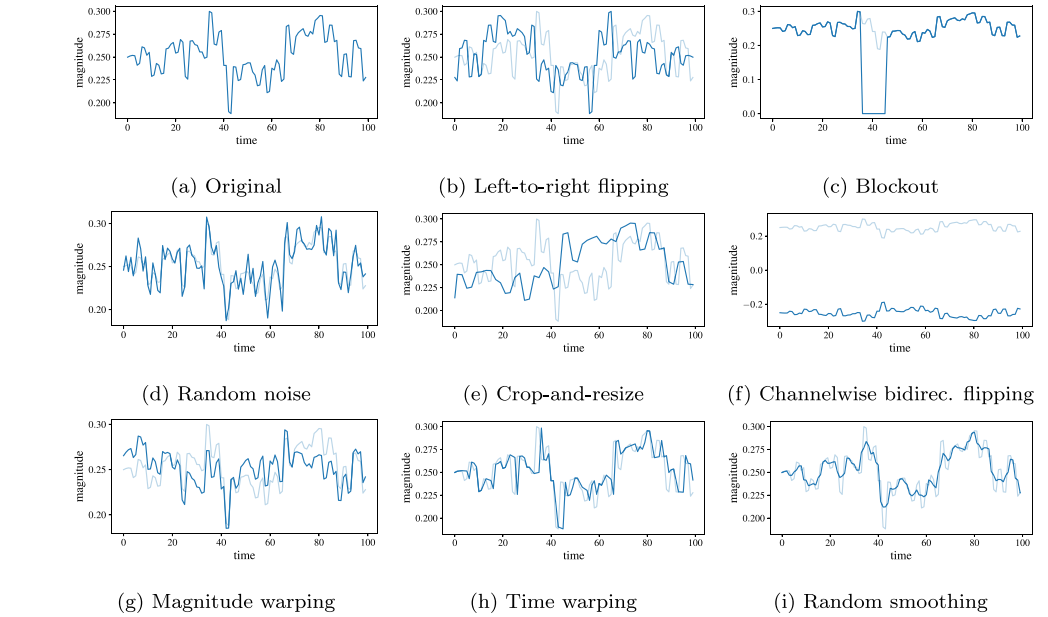


**Augmentation Results plotted byMathplotlib**


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from torch.utils.data import DataLoader, Dataset
import random
import pandas as pd

# Augmentation functions
def left_to_right_flip(series):
    return np.flip(series, axis=1)

def blockout(series, block_size=2, p=0.2):
    if random.random() > p:
        return series
    start_idx = random.randint(0, series.shape[1] - block_size)
    series[:, start_idx:start_idx + block_size] = 0
    return series


import numpy as np

def random_noise(series, stddev=0.1):
    # Ensure series is a numpy array
    series = np.asarray(series)

    # Generate noise and add it to the series
    noise = np.random.normal(0, stddev, series.shape)
    return series + noise


def crop_and_resize(series, crop_size=2):
    start_idx = random.randint(0, series.shape[1] - crop_size)
    cropped = series[:, start_idx:start_idx + crop_size]
    resized = np.pad(cropped, ((0, 0), (0, series.shape[1] - crop_size)), mode='constant')
    return resized

def magnitude_warping(series, magnitude=0.1):
    """Warp the magnitude of the time series"""
    series = np.array(series, dtype=np.float32)  # Ensure it's a float32 array
    factor = 1 + np.random.uniform(-magnitude, magnitude)
    return series * factor



def time_warping(series, warp_factor=0.2):
    indices = np.arange(series.shape[1])
    warp_indices = np.random.uniform(0, warp_factor, series.shape[1])
    warped_series = np.interp(indices + warp_indices, indices, series)
    return warped_series

def random_smoothing(series, window_size=3):
    return np.convolve(series, np.ones(window_size)/window_size, mode='same')


class TimeSeriesDataset(Dataset):
    def __init__(self, data, augmentations):
        self.data = data
        self.augmentations = augmentations

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        x = self.data[idx]
        x_aug1 = self.apply_random_augmentations(x)
        x_aug2 = self.apply_random_augmentations(x)

        # Ensure the data is of a numeric type
        x_aug1 = np.array(x_aug1, dtype=np.float32)
        x_aug2 = np.array(x_aug2, dtype=np.float32)

        # Ensure the tensors are contiguous
        return torch.tensor(x_aug1.copy(), dtype=torch.float32), torch.tensor(x_aug2.copy(), dtype=torch.float32)

    def apply_random_augmentations(self, series):
        aug = random.choice(self.augmentations)
        return aug(series)


# Encoder and Projection Head
class Encoder(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(Encoder, self).__init__()
        self.conv1 = nn.Conv1d(input_dim, hidden_dim, kernel_size=3, padding=1)
        self.conv2 = nn.Conv1d(hidden_dim, output_dim, kernel_size=3, padding=1)
        self.pool = nn.AdaptiveAvgPool1d(1)

    def forward(self, x):
        x = torch.relu(self.conv1(x))
        x = self.pool(torch.relu(self.conv2(x)))
        return x.squeeze(-1)

class ProjectionHead(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(ProjectionHead, self).__init__()
        self.fc1 = nn.Linear(input_dim, input_dim)
        self.fc2 = nn.Linear(input_dim, output_dim)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        return self.fc2(x)

# Contrastive loss function
class NTXentLoss(nn.Module):
    def __init__(self, batch_size, temperature):
        super(NTXentLoss, self).__init__()
        self.batch_size = batch_size
        self.temperature = temperature
        self.similarity_f = nn.CosineSimilarity(dim=2)

    def forward(self, z_i, z_j):
        z = torch.cat((z_i, z_j), dim=0)
        sim_matrix = self.similarity_f(z.unsqueeze(1), z.unsqueeze(0)) / self.temperature
        labels = torch.arange(self.batch_size).to(z.device)
        labels = torch.cat((labels, labels), dim=0)
        return nn.CrossEntropyLoss()(sim_matrix, labels)

# Training loop
def train_simclr_ts(data, input_dim, hidden_dim, output_dim, projection_dim, temperature, batch_size, epochs, lr):
    augmentations = [left_to_right_flip, blockout, random_noise, crop_and_resize, magnitude_warping, time_warping, random_smoothing]
    dataset = TimeSeriesDataset(data, augmentations)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

    encoder = Encoder(input_dim, hidden_dim, output_dim).to(device)
    projection_head = ProjectionHead(output_dim, projection_dim).to(device)
    ntxent_loss = NTXentLoss(batch_size, temperature).to(device)
    optimizer = optim.Adam(list(encoder.parameters()) + list(projection_head.parameters()), lr=lr)

    for epoch in range(epochs):
        for x_i, x_j in dataloader:
            x_i, x_j = x_i.to(device), x_j.to(device)

            # Encode and project
            h_i, h_j = encoder(x_i), encoder(x_j)
            z_i, z_j = projection_head(h_i), projection_head(h_j)

            # Calculate contrastive loss
            loss = ntxent_loss(z_i, z_j)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        print(f"Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}")

# Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load and preprocess data
data = pd.read_csv('/content/cleaned2_UWaveGestureLibrary_TRAIN.csv')  # Update the path accordingly
time_series_data = data.iloc[:, :-1].values  # Assuming the last column is the label, adjust if necessary
reshaped_data = time_series_data.reshape(60, 3, 4)  # Adjust this depending on your dataset
print(reshaped_data.shape)

# Start training
train_simclr_ts(reshaped_data, input_dim=3, hidden_dim=64, output_dim=128, projection_dim=64, temperature=0.5, batch_size=32, epochs=10, lr=1e-3)



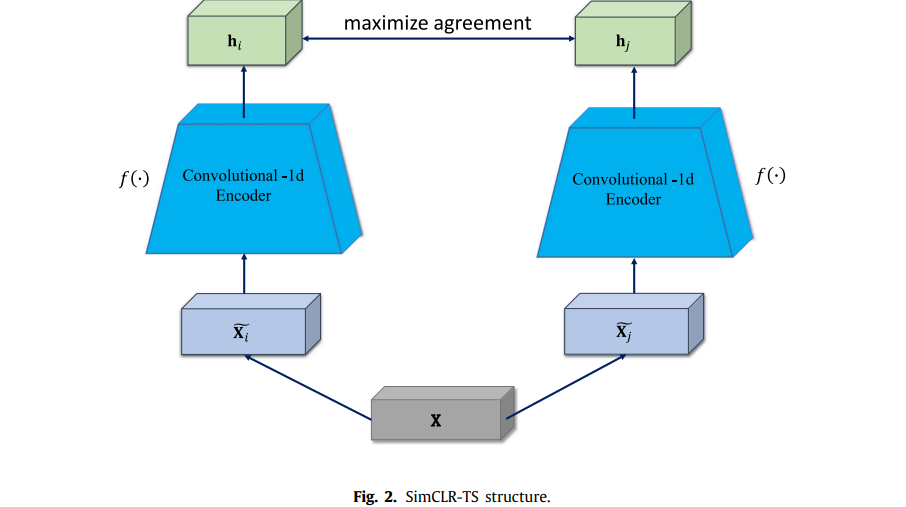

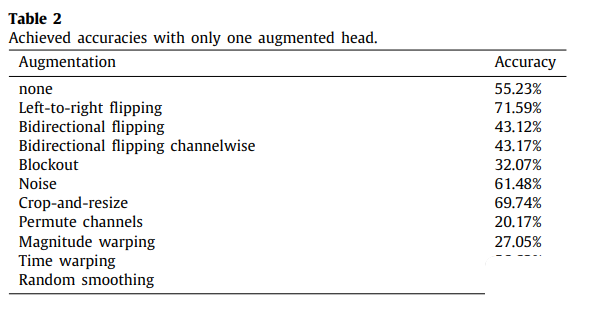


**Noted Accuracy for all the methods is depicted**